# Comparing Relaxation vs. Multigrid on the 2D Poisson Equation

### Objective

1. Solve a simple 2D Poisson equation using **Jacobi (or damped Jacobi)** relaxation.
2. Observe how the error becomes “smooth” after a few iterations.
3. Implement a **2-grid multigrid correction** step and see how it dramatically speeds up convergence.

---

## The Problem Setup

We’ll solve the **Poisson equation** on the unit square:
$$
\nabla^2 u = f(x, y), \quad (x,y) \in (0,1)\times(0,1)
$$
with **Dirichlet boundary conditions** (u = 0) on all sides.

Let’s choose a known analytic solution to test against:
$$
u(x, y) = \sin(\pi x)\sin(\pi y)
$$
Then the corresponding right-hand side is:
$$
f(x, y) = -2\pi^2 \sin(\pi x)\sin(\pi y)
$$

---

## Step 1 - Discretize

Use a uniform grid with spacing $h = 1/(N+1)$ for interior points.
The discrete Laplacian at a grid point $(i,j)$ is:
$$
(\nabla^2 u)*{i,j} \approx \frac{u*{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{h^2}
$$

So your discrete system is:
$$
L^h u^h = f^h
$$

---

## Step 2 - Implement Vanilla Jacobi Relaxation

Jacobi iteration:
$$
u_{i,j}^{(k+1)} = \frac{1}{4}\left(u_{i+1,j}^{(k)} + u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} + u_{i,j-1}^{(k)} - h^2 f_{i,j}\right)
$$

(Optional) **Damped Jacobi:**
$$
u^{(k+1)} = (1-\omega)u^{(k)} + \omega , u_{\text{Jacobi}}^{(k+1)}, \quad \text{where } 0<\omega<1
$$

* Run several iterations.
* Compute residual $r = L^h u - f^h$.
* Compute error $e = u_\text{exact} - u_\text{numerical}$.
* Plot both the **error** and **residual** after various iteration counts.

  * You’ll see they start “rough” (oscillating between adjacent points),
  * and become smooth after a few steps - even though their amplitude may still be large.

---

## Step 3 - Add a Two-Grid Multigrid Correction

Now we’ll perform one **V-cycle** iteration:

1. **Pre-smoothing:** Apply a few (say, 2) Jacobi sweeps on the fine grid.
2. **Compute residual:** $r^h = f^h - L^h u^h$.
3. **Restrict** residual to coarse grid: $r^{2h} = R(r^h)$, e.g. using full-weighting restriction:
   $$
   r_{I,J}^{2h} = \frac{1}{16}\left(4r_{2I,2J} + 2(r_{2I\pm1,2J} + r_{2I,2J\pm1}) + (r_{2I\pm1,2J\pm1})\right)
   $$
4. **Solve coarse grid correction:** $L^{2h} v^{2h} = r^{2h}$
   (You can do this recursively or directly with Jacobi.)
5. **Prolongate** correction to fine grid and update:
   $$
   u^h \leftarrow u^h + P(v^{2h})
   $$
   (e.g. bilinear interpolation for prolongation.)
6. **Post-smoothing:** Apply 1–2 Jacobi sweeps again.

Repeat this “V-cycle” several times and compare convergence.

---

## Step 4 - Compare Performance

Measure:

* **Residual norm** $||r||_2$ versus iteration count
* **Error norm** $||e||_2$
* Visualize error contours after:

  * 1, 5, 10 Jacobi sweeps (before MG)
  * 1 multigrid V-cycle

You’ll see that:

* Jacobi alone slowly damps only high-frequency errors.
* After 10 sweeps, the residual is smooth but not small.
* One MG V-cycle reduces the smooth residual much faster - showing how coarse grids accelerate convergence.


## Step 1: Setup and discretization

We’ll solve the **Poisson equation** on the unit square:
$$
\nabla^2 u = f(x, y), \quad (x,y) \in (0,1)\times(0,1)
$$
with homogeneous **Dirichlet boundary conditions** (u = 0) on all sides.

Let’s choose a known analytic solution to test against:
$$
u(x, y) = \sin(\pi x)\sin(\pi y)
$$
Then the corresponding right-hand side is:
$$
f(x, y) = -2\pi^2 \sin(\pi x)\sin(\pi y)
$$

In [35]:
using LinearAlgebra, Plots

# --- Problem setup ---
N = 64              # number of interior points per axis
h = 1.0 / (N + 1)   # grid spacing
x = range(h, step=h, length=N)
y = range(h, step=h, length=N)

# True solution and RHS
u_exact(x, y) = sin(pi*x) * sin(pi*y)
f_rhs(x, y)   = -2*pi^2 * sin(pi*x) * sin(pi*y)

# Initialize arrays
#u = zeros(N, N)             # simple numerical solution initial guess
u = [sin(8*pi*xi) * sin(8*pi*yj) for xi in x, yj in y]  # high-frequency numerical solution initial guess, for better visualization in graphs
f = [f_rhs(xi, yj) for xi in x, yj in y]   # RHS grid
u_true = [u_exact(xi, yj) for xi in x, yj in y]


64×64 Matrix{Float64}:
 0.00233418  0.00466291  0.00698075  …  0.00698075  0.00466291  0.00233418
 0.00466291  0.00931494  0.0139452      0.0139452   0.00931494  0.00466291
 0.00698075  0.0139452   0.0208771      0.0208771   0.0139452   0.00698075
 0.00928229  0.0185429   0.0277602      0.0277602   0.0185429   0.00928229
 0.0115621   0.0230973   0.0345785      0.0345785   0.0230973   0.0115621
 0.013815    0.0275977   0.041316    …  0.041316    0.0275977   0.013815
 0.0160356   0.0320337   0.0479571      0.0479571   0.0320337   0.0160356
 0.0182187   0.0363949   0.0544861      0.0544861   0.0363949   0.0182187
 0.0203593   0.0406711   0.0608878      0.0608878   0.0406711   0.0203593
 0.0224523   0.0448523   0.0671474      0.0671474   0.0448523   0.0224523
 0.0244929   0.0489287   0.0732501   …  0.0732501   0.0489287   0.0244929
 0.0264763   0.0528908   0.0791818      0.0791818   0.0528908   0.0264763
 0.0283979   0.0567295   0.0849285      0.0849285   0.0567295   0.0283979
 ⋮          

## Step 2 - Implement Vanilla Jacobi Relaxation

Jacobi iteration:
$$
u_{i,j}^{(k+1)} = \frac{1}{4}\left(u_{i+1,j}^{(k)} + u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} + u_{i,j-1}^{(k)} - h^2 f_{i,j}\right)
$$

In [36]:
function jacobi_step(u, f, h)
    N = size(u, 1)
    u_new = copy(u)
    for j in 2:N-1
        for i in 2:N-1
            u_new[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - h^2 * f[i, j])
        end
    end
    return u_new
end

function residual(u, f, h)
    N = size(u, 1)
    r = zeros(N, N)
    for j in 2:N-1
        for i in 2:N-1
            r[i, j] = (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4*u[i, j]) / h^2 - f[i, j]
        end
    end
    return r
end


residual (generic function with 1 method)

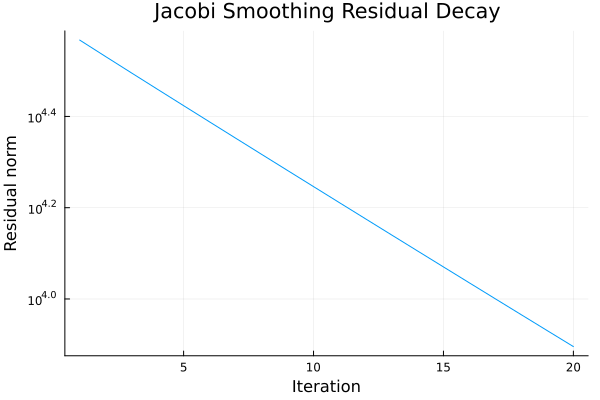

In [37]:
num_iters = 20
residual_norms = zeros(num_iters)
r = residual(u, f, h)   # initialize r so it exists outside the loop
snapshots = Dict{Int, Matrix{Float64}}()  # for storing snapshots of the residual array periodically

for k in 1:num_iters
    u = jacobi_step(u, f, h)
    r = residual(u, f, h)   # update residual array every step (overwrite)
    if k in [1,2,6,8]
        snapshots[k] = copy(r)
    end
    residual_norms[k] = norm(r)
end

plot(residual_norms, yscale=:log10, xlabel="Iteration", ylabel="Residual norm",
     title="Jacobi Smoothing Residual Decay", legend=false)

In [38]:
snapshots

Dict{Int64, Matrix{Float64}} with 4 entries:
  6 => [0.0 0.0 … 0.0 0.0; 0.0 -162.39 … 162.573 0.0; … ; 0.0 162.573 … -162.39…
  2 => [0.0 0.0 … 0.0 0.0; 0.0 -315.961 … 316.202 0.0; … ; 0.0 316.202 … -315.9…
  8 => [0.0 0.0 … 0.0 0.0; 0.0 -125.158 … 125.328 0.0; … ; 0.0 125.328 … -125.1…
  1 => [0.0 0.0 … 0.0 0.0; 0.0 -399.353 … 399.628 0.0; … ; 0.0 399.628 … -399.3…

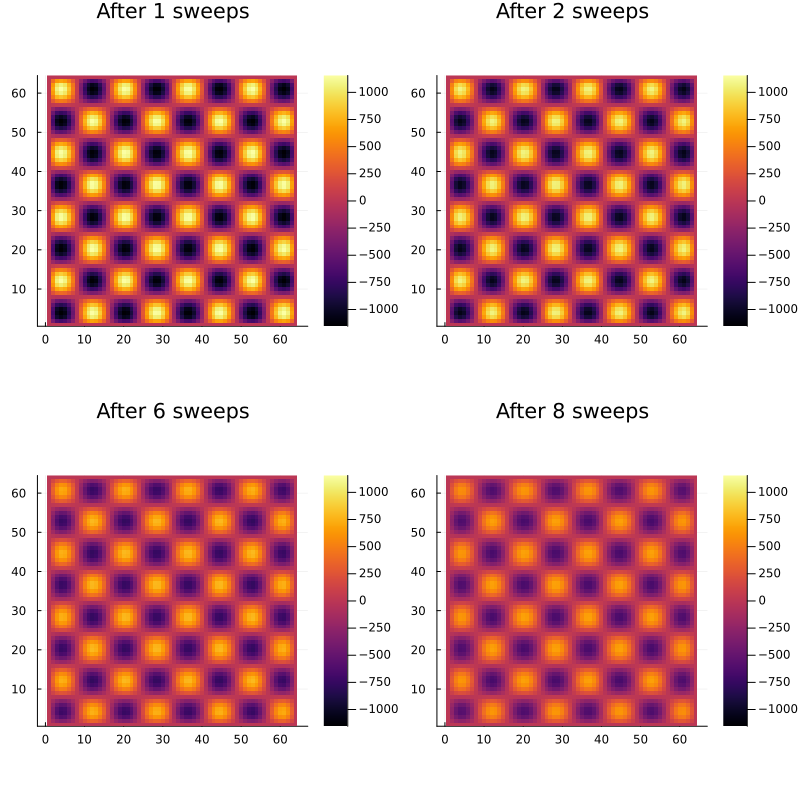

In [39]:
plots = []

# Compute global min/max across all snapshots
vmin = minimum([minimum(r) for r in values(snapshots)])
vmax = maximum([maximum(r) for r in values(snapshots)])

for (k, r_snap) in sort(collect(snapshots), by = first)
    push!(plots, heatmap(r_snap, title="After $k sweeps", aspect_ratio=1, clims=(vmin, vmax)))
end

plot(plots..., layout=(2,2), size=(800,800))

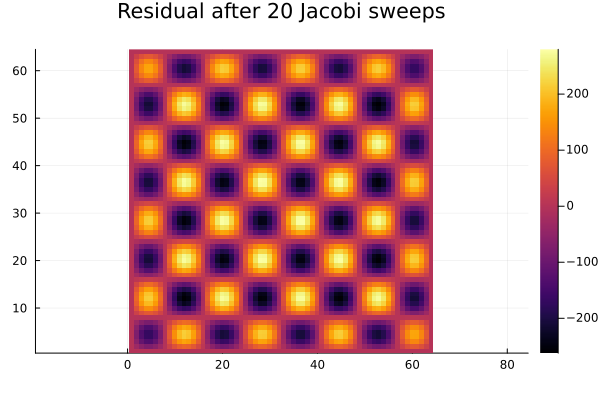

In [40]:
heatmap(r, title="Residual after $num_iters Jacobi sweeps", aspect_ratio=1)

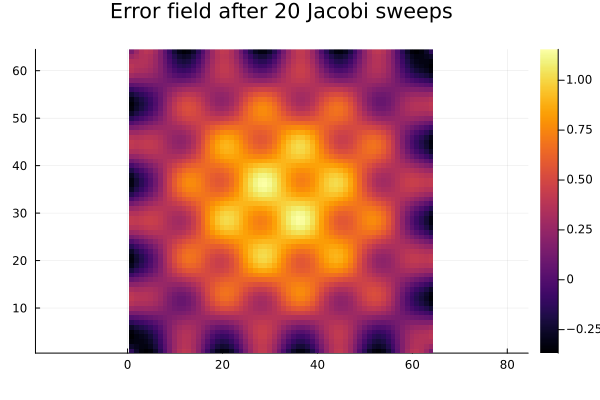

In [41]:
err = u_true .- u
heatmap(err, title="Error field after $num_iters Jacobi sweeps", aspect_ratio=1)

## Step 3 - Add a Two-Grid Multigrid Correction

Now we’ll perform one **V-cycle** iteration:

1. **Pre-smoothing:** Apply a few (say, 2) Jacobi sweeps on the fine grid.
2. **Compute residual:** $r^h = f^h - L^h u^h$.
3. **Restrict** residual to coarse grid: $r^{2h} = R(r^h)$, e.g. using full-weighting restriction:
   $$
   r_{I,J}^{2h} = \frac{1}{16}\left(4r_{2I,2J} + 2(r_{2I\pm1,2J} + r_{2I,2J\pm1}) + (r_{2I\pm1,2J\pm1})\right)
   $$
4. **Solve coarse grid correction:** $L^{2h} v^{2h} = r^{2h}$
   (You can do this recursively or directly with Jacobi.)
5. **Prolongate** correction to fine grid and update:
   $$
   u^h \leftarrow u^h + P(v^{2h})
   $$
   (e.g. bilinear interpolation for prolongation.)
6. **Post-smoothing:** Apply 1–2 Jacobi sweeps again.

Repeat this “V-cycle” several times and compare convergence.

In [42]:
# Restrction funcion
function restrict_full_weighting(r)
    Nf = size(r, 1)
    Nc = div(Nf, 2)
    r2h = zeros(Nc, Nc)

    for J in 2:Nc-1
        for I in 2:Nc-1
            i, j = 2*I, 2*J
            r2h[I, J] = (1/16) * (
                4*r[i, j] +
                2*(r[i-1, j] + r[i+1, j] + r[i, j-1] + r[i, j+1]) +
                (r[i-1, j-1] + r[i-1, j+1] + r[i+1, j-1] + r[i+1, j+1])
            )
        end
    end

    return r2h
end

restrict_full_weighting (generic function with 1 method)

In [43]:
# Prolongation function, bilinear interpolation
function prolong_bilinear(v2h)
    Nc = size(v2h, 1)
    Nf = 2 * Nc
    vh = zeros(Nf, Nf)

    for J in 1:Nc
        for I in 1:Nc
            i, j = 2*I, 2*J
            vh[i, j] += v2h[I, J]
        end
    end

    # interpolate edges
    for j in 2:2:Nf-2
        for i in 3:2:Nf-1
            vh[i, j] = 0.5 * (vh[i-1, j] + vh[i+1, j])
        end
    end
    for j in 3:2:Nf-1
        for i in 2:Nf-1
            vh[i, j] = 0.5 * (vh[i, j-1] + vh[i, j+1])
        end
    end

    return vh
end

prolong_bilinear (generic function with 1 method)

In [44]:
function vcycle(u, f, h; nu1=2, nu2=1)
    # Pre-smoothing (nu1 Jacobi sweeps)
    for _ in 1:nu1
        u = jacobi_step(u, f, h)
    end

    # Compute residual and restrict
    r = residual(u, f, h)
    r2h = restrict_full_weighting(r)

    # Coarse grid spacing
    h2 = 2h
    Nc = size(r2h, 1)

    # Initialize coarse-grid correction
    v2h = zeros(Nc, Nc)

    # Solve coarse problem by a few Jacobi iterations
    f_coarse = -r2h
    for _ in 1:20
        v2h = jacobi_step(v2h, f_coarse, h2)
    end

    # Prolongate correction and update
    vh = prolong_bilinear(v2h)
    u += vh

    # Post-smoothing (nu2 Jacobi sweeps)
    for _ in 1:nu2
        u = jacobi_step(u, f, h)
    end
    
    return u
end

vcycle (generic function with 1 method)

## Step 4 - Compare Performance

Measure:

* **Residual norm** $||r||_2$ versus iteration count 
* **Error norm** $||e||_2$

In [49]:
# Reset initial guesses
u_jacobi = [sin(8*pi*xi) * sin(8*pi*yj) for xi in x, yj in y]
u_mg = copy(u_jacobi)

num_iters = 30
res_jacobi = zeros(num_iters)
res_mg = zeros(num_iters)
err_jacobi = zeros(num_iters)
err_mg = zeros(num_iters)

for k in 1:num_iters
    # --- Jacobi ---
    u_jacobi = jacobi_step(u_jacobi, f, h)
    res_jacobi[k] = norm(residual(u_jacobi, f, h))
    err_jacobi[k] = norm(u_jacobi .- u_true)

    # --- Multigrid ---
    u_mg = vcycle(u_mg, f, h)
    res_mg[k] = norm(residual(u_mg, f, h))
    err_mg[k] = norm(u_mg .- u_true)
end

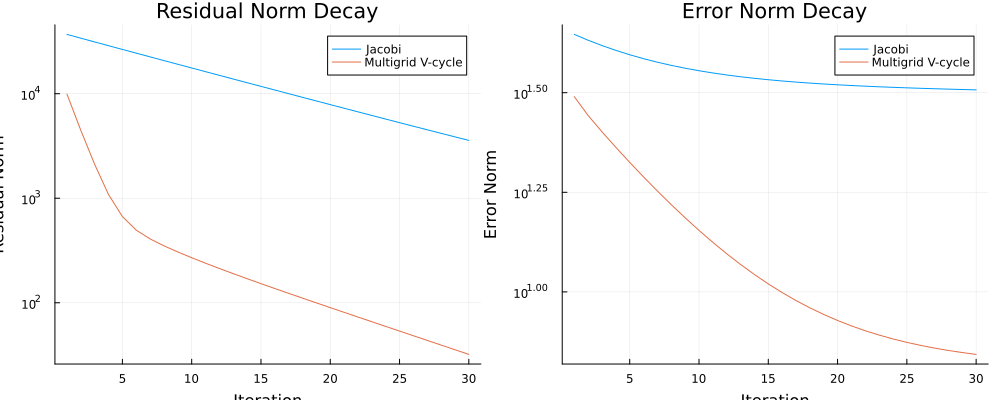

In [50]:
p1 = plot(1:num_iters, [res_jacobi res_mg],
          labels=["Jacobi" "Multigrid V-cycle"],
          yscale=:log10, xlabel="Iteration", ylabel="Residual Norm",
          title="Residual Norm Decay")

p2 = plot(1:num_iters, [err_jacobi err_mg],
          labels=["Jacobi" "Multigrid V-cycle"],
          yscale=:log10, xlabel="Iteration", ylabel="Error Norm",
          title="Error Norm Decay")

plot(p1, p2, layout=(1,2), size=(1000,400))